**Load Libraries**

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold

**Reading and checking data**

In [2]:
df = pd.read_csv("../input/diabetes-data-set/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


**Calculate zero values**

In [3]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0, np.NaN)
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

**Replace zero values with mean based on outcome**

In [4]:
columns = df.columns
columns = columns.drop(["Outcome", "Pregnancies"])

for col in columns:
    for i in range(2):
        df.loc[(df['Outcome'] == i ) & (df[col].isnull()), col] = df[df[col].notnull()][[col, 'Outcome']].groupby(['Outcome'])[[col]].median().reset_index()[col][i]

**Split data**

In [5]:
y = df['Outcome']
X = df.drop('Outcome', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=8888, stratify = df['Outcome'])
cols = X.columns
index = X.index

**Scaling**

In [6]:
transformer = RobustScaler().fit(X)
X = transformer.transform(X)
X = pd.DataFrame(X, columns = cols, index = index)

**Modeling**

In [7]:
models = []

models.append(('LR', LogisticRegression(random_state = 8888)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state = 8888)))
models.append(('RF', RandomForestClassifier(random_state = 8888)))
models.append(('SVM', SVC(gamma='auto', random_state = 8888)))
models.append(('XGB', GradientBoostingClassifier(random_state = 8888)))
models.append(("LightGBM", LGBMClassifier(random_state = 8888)))

# evaluate each model in turn
results = []
names = []

LR: 0.776042 (0.035798)
KNN: 0.856801 (0.023846)
CART: 0.847676 (0.031332)
RF: 0.880280 (0.039987)
SVM: 0.855434 (0.026476)
XGB: 0.880297 (0.026837)
LightGBM: 0.876367 (0.030136)


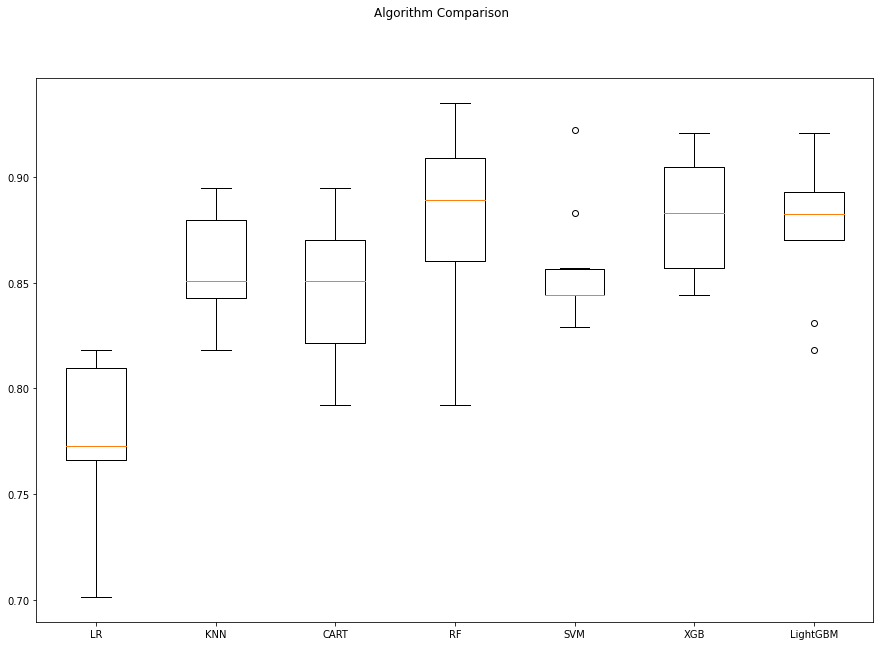

In [8]:
for name, model in models:
        kfold = KFold(n_splits = 10, shuffle=True, random_state = 8888)
        cv_results = cross_val_score(model, X, y, cv = 10, scoring= "accuracy")
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()